# Simulator sandbox

This code is to follow `model_tuner_tester.py` to train the simulator (future) class on the data from model tuner.

## load data

In [2]:
import pandas as pd

raw = None
for split_seed in range(10):
    if raw is None:
        raw = pd.read_csv(f'../model_cls/seed_{split_seed}.csv')
    else:
        raw = pd.concat( [raw, pd.read_csv(f'../model_cls/seed_{split_seed}.csv') ])

# NOTE: the data is already shuffled
# NOTE: there will be (ticker, earnings_date) duplicates, so we avg out below

In [33]:
# properties dataframe
props = raw.groupby(['ticker','earnings_date','eps_actual','eps_diff','price_var']).mean()[['pred']].reset_index().set_index(['ticker','earnings_date']).sort_index()

In [13]:
import sqlite3
import numpy as np
from matplotlib import pyplot as plt
import datetime

database = "../main.db"

# conn.close() # comment this if running the first time
conn = sqlite3.connect(database)

In [6]:
hist_q = """
    SELECT 
        ticker,
        DATE(trade_date) trade_date,
        close,
        low,
        high,
        volume
    FROM yf_history 
"""
hist  = pd.read_sql_query(hist_q,conn)

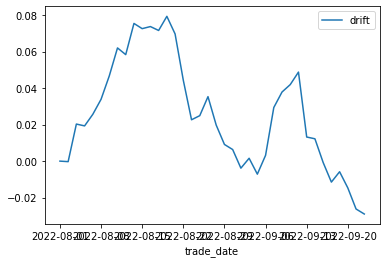

In [51]:
def get_data_for(ticker: str, earnings_date: str, hist_period: int = 4*2, plot=False) -> tuple:
    #raw.sample().transpose()
    prop = props.loc[ticker, earnings_date]#.head(1).reset_index().transpose()
    hist_end = (datetime.datetime.strptime(earnings_date, "%Y-%m-%d") + datetime.timedelta(weeks=hist_period)).strftime("%Y-%m-%d")
    h = hist[(hist.ticker==ticker) & (hist.trade_date>earnings_date) & (hist.trade_date<hist_end)].reset_index()
    init_close = h.head(1).close.values[0]
    h['drift'] = h.close/init_close-1.0

    if plot:
        h.plot('trade_date','drift')

    return prop, h

prop, h = get_data_for('AON','2022-07-29', plot=True)

In [60]:
def simulate_trade(drift, sell_pct = 0.05, stop_loss = -0.01) -> float:
    for d in drift:
        if d<=stop_loss or d>=sell_pct:
            break
    return d

def simulation_grid(h, 
        sell_pct_arr = [.02, .05, .08, .10, .15, .20],
        stop_loss_arr= [-.02, -.05, -.08, -.10, -.15, -.20]
        ):
    drift = h.drift.to_list()
    for sell_pct in sell_pct_arr:
        for stop_loss in stop_loss_arr:
            gain = simulate_trade(drift, sell_pct, stop_loss)
            
            print(f"final gain for sell_pct {sell_pct} and stop_loss {stop_loss}: {round(gain,2)}")

simulation_grid(h)

final gain for sell_pct 0.02 and stop_loss -0.02: 0.02
final gain for sell_pct 0.02 and stop_loss -0.05: 0.02
final gain for sell_pct 0.02 and stop_loss -0.08: 0.02
final gain for sell_pct 0.02 and stop_loss -0.1: 0.02
final gain for sell_pct 0.02 and stop_loss -0.15: 0.02
final gain for sell_pct 0.02 and stop_loss -0.2: 0.02
final gain for sell_pct 0.05 and stop_loss -0.02: 0.06
final gain for sell_pct 0.05 and stop_loss -0.05: 0.06
final gain for sell_pct 0.05 and stop_loss -0.08: 0.06
final gain for sell_pct 0.05 and stop_loss -0.1: 0.06
final gain for sell_pct 0.05 and stop_loss -0.15: 0.06
final gain for sell_pct 0.05 and stop_loss -0.2: 0.06
final gain for sell_pct 0.08 and stop_loss -0.02: -0.03
final gain for sell_pct 0.08 and stop_loss -0.05: -0.03
final gain for sell_pct 0.08 and stop_loss -0.08: -0.03
final gain for sell_pct 0.08 and stop_loss -0.1: -0.03
final gain for sell_pct 0.08 and stop_loss -0.15: -0.03
final gain for sell_pct 0.08 and stop_loss -0.2: -0.03
final gain